# Epigen Analysis

This notebook runs epigen data generation including:
1. generating model .xml files
2. generating epigen merged ccorpora
3. running sweep over alpha values to set the risk scores for additive/interactive effects
4. generating final epigen datasets for CEU and ASW populations

In [1]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import glob
import json
import joblib
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt

from simulate_data import * #epigen-provided file. see below* for modification to epigen to allow it to read in np files
from merge_genotype_corpora import *
from generate_modelxml import *

*Epigen note: epigen has to be modified to let it read in numpy files (numpy files are faster to load); also fixed one epigen typo in merging.

Modifications below:


1) Line 100 of `epigen/utils/data_simulator.py` modified with the following addition:
```
    ##### ADDED BY DIVYA
    elif os.path.exists("corpora/" + str(corpus_id) + "_" + pop + "_genotype.npy"):
        self.corpus_genotype = np.load("corpora/" + str(corpus_id) + "_" + pop + "_genotype.npy")
    #####
```

2) Line 97 of `epigen/utils/genotype_corpus_merger.py`:
```
    ##### ADDED BY DIVYA
    elif os.path.exists("corpora/" + str(corpus_id) + "_" + pop + "_genotype.npy"):
        self.genotype = np.load("corpora/" + str(corpus_id) + "_" + pop + "_genotype.npy")
    #####
```
        
3) Line 124 of `epigen/utils/genotype_corpus_merger.py` has a typo that prevents it from merging correctly. Fix this typo:
```
    # pop = self.pops[0]

    #### ADDED BY DIVYA - above line seems like a typo
    pop = self.pops[pos]
    ####
 ```

4) Line 142 of `epigen/utils/genotype_corpus_merger.py`:
```
    ##### ADDED BY DIVYA
    elif os.path.exists("corpora/" + str(corpus_id) + "_" + pop + "_genotype.npy"):
        try:
            self.genotype = np.append(self.genotype, np.load("corpora/" + str(corpus_id) + "_" + pop + "_genotype.npy"), axis=self.axis)
        except:
            raise ValueError("Wrong array dimensions. Cannot merge along axis {}.".format(self.axis))
    #####
```         
            
4) Line 220:`epigen/utils/genotype_corpus_merger.py`:
```
    #### ADDED BY DIVYA
    # with open("corpora/" + str(self.corpus_id) + "_" + self.pop + "_genotype.json", "wt", encoding="ascii") as jsonfile:
    #     json.dump(self.genotype.tolist(), jsonfile)
    np.save("corpora/" + str(self.corpus_id) + "_" + self.pop + "_genotype.npy", self.genotype)    
    ####     
```

## Helper functions

In [6]:
def get_pop_labels(geno, n_pops=2, n_snps=1000):
    '''Use small sample of snps (like 1k) to quickly assign population groups - for use in resampling'''
    km = KMeans(n_clusters=n_pops).fit(geno[:, :n_snps])
    return km.labels_

def generate_epigen(pop='CEU',popnum=1, num_sims=1, epigen_inds=7500, alpha=1.21, downsample=False, final_inds=None, pset='epigen'):
    # hardcoded params
    corpus_id = 122
    snps = 100000
    disease_maf_range = [0.05, 0.95]
    seed = 0
    num_disease_snps = int(snps*0.005)  #instead of specifiying indices of disease snps, instead we provide the number disease snps, which gets set within the xml file. see generate_xml.py.
    inds = epigen_inds
    # default params
    biased_distr = []
    disease_snps = []
    noise_maf_range = [0,1]
    compress = False
    
    # generate xml file
    model = 'models/param_model_simulation_alpha_{}.xml'.format(alpha)
    generate_xml(alpha, savename=model, num_disease_snps=num_disease_snps)
    
    # run epigen
    sim_ids = [i for i in range(num_sims*2)] #add buffer for num sims in case some are too small to downsample; keep counter to stop at 10 complete sims
    sim = DataSim(corpus_id, pop, model, snps, inds, disease_snps, biased_distr, noise_maf_range, disease_maf_range, seed, compress)
    
    save_count = 0
    for index in range(len(sim_ids)):
        
        sim.set_sim_id(sim_ids[index])
        sim.sample_snps()
        sim.generate_phenotype()
        valcounts = np.unique(sim.phenotype, return_counts=True)
        print('pop', pop, 'alpha:', alpha, valcounts)

        #print breakdown by population label
        case_ind = {}
        ctr_ind = {}
        sim_klabel = get_pop_labels(sim.genotype.T, n_pops=popnum)
        for p in range(popnum):
            case_ind[p]=np.where((sim.phenotype==1)&(sim_klabel==p))[0]
            ctr_ind[p]=np.where((sim.phenotype==0)&(sim_klabel==p))[0]
            print('pop {}, case: {}, ctr: {}'.format(p, len(case_ind[p]), len(ctr_ind[p])))
        # downsample dataset to balanced case_control
        if downsample:
            try:
                num_sample = int((final_inds/popnum)/2)
                downsample_sim(sim, pset, popnum, num_sample, case_ind, ctr_ind, sim_klabel, seed, save_count+1)
                save_count += 1
                if save_count == 10:
                    print('Done simulating!')
                    break
            except AssertionError:
                print('Not enough samples; Trying next simulation...')
                
def downsample_sim(sim, pset, popnum, num_sample, case_ind, ctr_ind, sim_klabel, seed, sim_id):
    '''Downsample epigen simulation to matrix with balanced case and controls, and balanced population sizes'''
    prng = np.random.RandomState(seed)
    all_samp = []
    for p in range(popnum):
        assert (len(case_ind[p])> num_sample)&(len(ctr_ind[p])> num_sample), 'decrease num samples'
        case_ind[p]=prng.choice(case_ind[p], size=num_sample, replace=False)
        ctr_ind[p]=prng.choice(ctr_ind[p], size=num_sample, replace=False)
        all_samp.append(case_ind[p])
        all_samp.append(ctr_ind[p])
    all_samp = np.hstack(all_samp)
    prng.shuffle(all_samp) #shuffle all samp vector

    # get corresponding y and pop data
    y_label = sim.phenotype[all_samp]
    pop_label = sim_klabel[all_samp]
    disease_snps = sim.disease_snps
    snp_metadata = np.array(sim.snps)
    genotype_sampled = sim.genotype[:, all_samp]

    # save matrices
    savepath = 'sim'
    fpath = '{}/{}'.format(savepath, pset)
    Path(fpath).mkdir(parents=True, exist_ok=True)
    np.savetxt('{}/ysim.{}.txt'.format(fpath, sim_id), y_label)
    np.savetxt('{}/pop_label.{}.txt'.format(fpath, sim_id), pop_label)
    np.savetxt('{}/disease_snps.{}.txt'.format(fpath, sim_id), disease_snps)
    np.save('{}/snp_metadata.{}'.format(fpath, sim_id), snp_metadata)
    np.save('{}/Xsim.{}'.format(fpath, sim_id), genotype_sampled)

# Merge epigen populations: CEU + ASW

Initializing the merger ... 
Merging genotype corpora ...
Computing MAFs ... 
Serializing the genotype corpus ... 
CPU times: user 1min 33s, sys: 7min 59s, total: 9min 33s
Wall time: 10min 20s


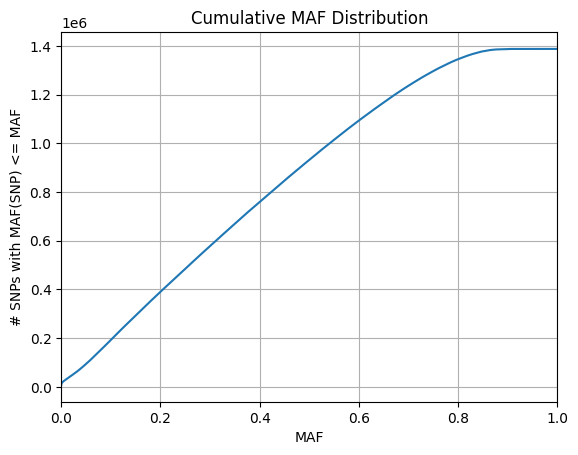

In [109]:
%%time

corpus_ids = [122, 122]
pops = ['CEU', 'ASW']
corpus_id = 122
axis = 1
compress=False
merger = GenCorMerge(corpus_ids, pops, corpus_id, axis, compress)
merger.merge_corpora()
merger.compute_mafs()
merger.dump_corpus()

In [196]:
#double check that epigen is now merging correctly; assert that snps in both individual corpora are identical
ceu_path = 'corpora/122_CEU_snps.json'
asw_path = 'corpora/122_ASW_snps.json'

with open(ceu_path , "r" ) as ceu_file:
    ceu_snps = json.load(ceu_file)
with open(asw_path , "r" ) as asw_file:
    asw_snps = json.load(asw_file)
    
assert asw_snps==ceu_snps

# Run sweep over alpha values

Epigen results vary depending on snp risk effect sizes; a sweep was used to select the risk effect sizes (alpha) that returned the most balanced case-control dataset.

In [5]:
%%time
alpha_list = [1.185] #1.190, 1.195
for alpha in alpha_list:
    generate_epigen(pop='MIX', popnum=2, num_sims=1, epigen_inds=20000, alpha=alpha)

Loading genotype corpus.
Genotype corpus contains 1387466 SNPs and 20000 individuals.
Loading SNPs.
Loading MAFs.
Loading cumulative MAF distribution.
Parsing epistasis model.
Checking input consistency.
----------------------------------------------------------------------------
Starting simulation for simulation ID 0.
Checking disease MAF range (extend if too narrow).
Checking noise MAF range (extend if too narrow).
Sampling disease SNPs.
Sampling noise SNPs.
Updating genotype matrix, MAF array, and SNP list.
Generating the phenotypes.
Subsampling the individuals.
pop MIX alpha: 1.185 (array([0, 1]), array([10383,  9617]))
pop 0, case: 1315, ctr: 8684
pop 1, case: 8302, ctr: 1699
CPU times: user 3min 42s, sys: 1min 50s, total: 5min 32s
Wall time: 3min 15s


# Generate epigen output
Downsample to 5k; save in format similar to ltsim/ALS/Diabetes

Saved format:


In [64]:
sel_alpha = 1.185
cnum_sims = 10
generate_epigen(pop='MIX', popnum=2, num_sims=cnum_sims, epigen_inds=20000, alpha=sel_alpha, downsample=True, final_inds=5000,pset='epigen_ceu_asw')



Loading genotype corpus.
Genotype corpus contains 1387466 SNPs and 20000 individuals.
Loading SNPs.
Loading MAFs.
Loading cumulative MAF distribution.
Parsing epistasis model.
Checking input consistency.
----------------------------------------------------------------------------
Starting simulation for simulation ID 0.
Checking disease MAF range (extend if too narrow).
Checking noise MAF range (extend if too narrow).
Sampling disease SNPs.
Sampling noise SNPs.
Updating genotype matrix, MAF array, and SNP list.
Generating the phenotypes.
Subsampling the individuals.
pop MIX alpha: 1.185 (array([0, 1]), array([10383,  9617]))
pop 0, case: 1315, ctr: 8684
pop 1, case: 8302, ctr: 1699
----------------------------------------------------------------------------
Starting simulation for simulation ID 1.
Checking disease MAF range (extend if too narrow).
Checking noise MAF range (extend if too narrow).
Sampling disease SNPs.
Sampling noise SNPs.
Updating genotype matrix, MAF array, and SNP li

pop 0, case: 6269, ctr: 3731
pop 1, case: 543, ctr: 9457
Not enough samples; Trying next simulation...
----------------------------------------------------------------------------
Starting simulation for simulation ID 16.
Checking disease MAF range (extend if too narrow).
Checking noise MAF range (extend if too narrow).
Sampling disease SNPs.
Sampling noise SNPs.
Updating genotype matrix, MAF array, and SNP list.
Generating the phenotypes.
Subsampling the individuals.
pop MIX alpha: 1.185 (array([0, 1]), array([10241,  9759]))
pop 0, case: 8022, ctr: 1978
pop 1, case: 1737, ctr: 8263
Done simulating!


In [7]:
sel_alpha = 1.185
cnum_sims = 10
generate_epigen(pop='CEU', popnum=1, num_sims=cnum_sims, epigen_inds=7500, alpha=sel_alpha, downsample=True, final_inds=5000,pset='epigen_ceu')



Loading genotype corpus.
Genotype corpus contains 1387466 SNPs and 10000 individuals.
Loading SNPs.
Loading MAFs.
Loading cumulative MAF distribution.
Parsing epistasis model.
Checking input consistency.
----------------------------------------------------------------------------
Starting simulation for simulation ID 0.
Checking disease MAF range (extend if too narrow).
Checking noise MAF range (extend if too narrow).
Sampling disease SNPs.
Sampling noise SNPs.
Updating genotype matrix, MAF array, and SNP list.
Generating the phenotypes.
Subsampling the individuals.
pop CEU alpha: 1.185 (array([0, 1]), array([3094, 4406]))
pop 0, case: 4406, ctr: 3094
----------------------------------------------------------------------------
Starting simulation for simulation ID 1.
Checking disease MAF range (extend if too narrow).
Checking noise MAF range (extend if too narrow).
Sampling disease SNPs.
Sampling noise SNPs.
Updating genotype matrix, MAF array, and SNP list.
Generating the phenotypes.


# Make PCA plots of replicates

In [65]:
def pca_calc(geno, pheno, poparr=None, standardize=True):
    if standardize:
        df_snp_std = preprocessing.StandardScaler().fit_transform(geno)
    else:
        df_snp_std = geno
        
    # Fit and transform
    n_components = 10
    snp_pca = PCA(n_components=n_components, svd_solver = 'arpack', random_state = 1)
    np_snp_pca = snp_pca.fit_transform(df_snp_std)

    df_snp_pca = pd.DataFrame(np_snp_pca, columns = ['PC' + str(x) for x in range(1, n_components + 1)])
    df_snp_pca_p = df_snp_pca.join(pd.DataFrame(pheno, columns=['phenotype']))
    if poparr is not None:
        df_snp_pca_p = df_snp_pca_p.join(pd.DataFrame(poparr, columns=['population']))
        
    return df_snp_pca_p

In [ ]:
%%time
sim_dir = 'sim/epigen_ceu_asw'

pca_df_dict = {}
for i, file in enumerate(glob.glob(sim_dir + '/Xsim.*.npy')):
    cur_simnum = file.split('.')[-2]
    geno = np.load(file).T
    pheno = np.loadtxt('{}/ysim.{}.txt'.format(sim_dir, cur_simnum))
    poplabel = np.loadtxt('{}/pop_label.{}.txt'.format(sim_dir, cur_simnum))
    pca_df = pca_calc(geno, pheno, poparr=poplabel)
    pca_df_dict[i]=pca_df

In [77]:
joblib.dump(pca_df_dict, 'sim/epigen_ceu_asw/pca_save.pkl')

['sim/epigen_ceu_asw/pca_save.pkl']

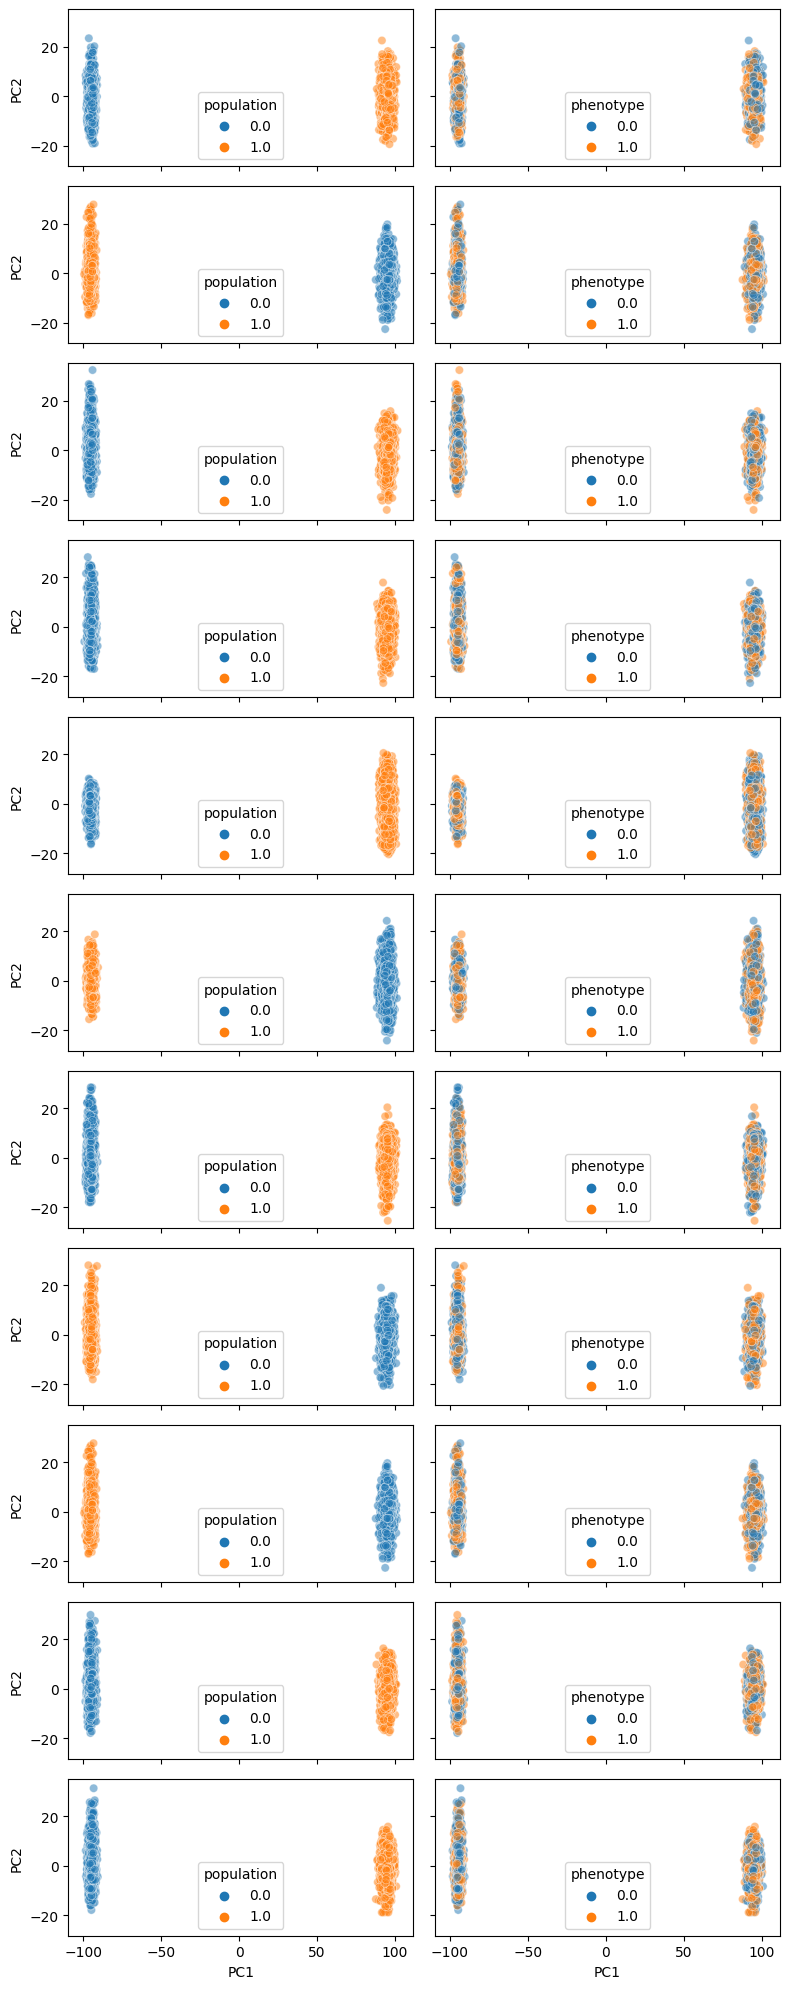

In [78]:
fig, axs = plt.subplots(11,2, figsize=(8,20), sharex=True, sharey=True)
for i, f in enumerate(pca_df_dict):
    pca_df = pca_df_dict[f]
    _ = sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="population", alpha=0.5, ax=axs[i, 0]) 
    _ = sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="phenotype", alpha=0.5, ax=axs[i, 1]) 
fig.tight_layout()